<a href="https://colab.research.google.com/drive/1OeBuChDPxM51K_HGBZ1Iqf3gXO1Bhjlh?usp=sharing" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>

In [1]:
# Step 1: Install required libraries
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00


In [2]:
# Step 2: Import necessary libraries
import torch
import clip
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Step 3: Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 44.1MiB/s]


In [4]:
# Step 4: Load CIFAR-10 dataset
# We only need the test set for inference
# Images are resized to 224x224 to match CLIP's expected input size
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

cifar10 = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
dataloader = DataLoader(cifar10, batch_size=1, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


In [5]:
# Step 5: Define text prompts for each CIFAR-10 class
text_labels = [
    "a photo of an airplane",
    "a photo of a car",
    "a photo of a bird",
    "a photo of a cat",
    "a photo of a deer",
    "a photo of a dog",
    "a photo of a frog",
    "a photo of a horse",
    "a photo of a ship",
    "a photo of a truck"
]

# Tokenize text prompts for CLIP
text_inputs = torch.cat([clip.tokenize(label) for label in text_labels]).to(device)


In [6]:
# Step 6: Define class name mapping (CIFAR-10 labels)
class_names = cifar10.classes


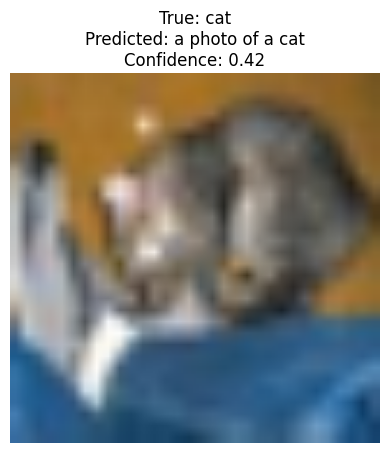

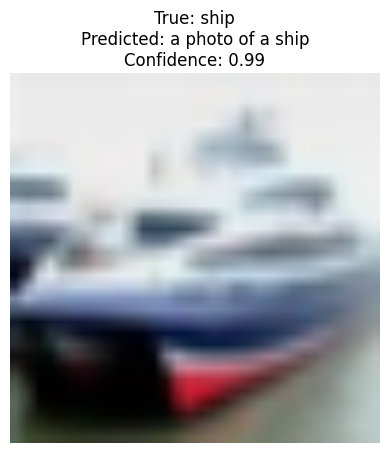

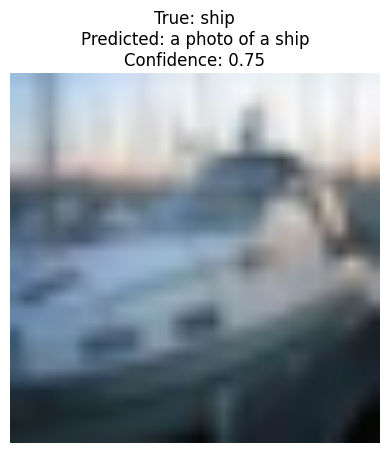

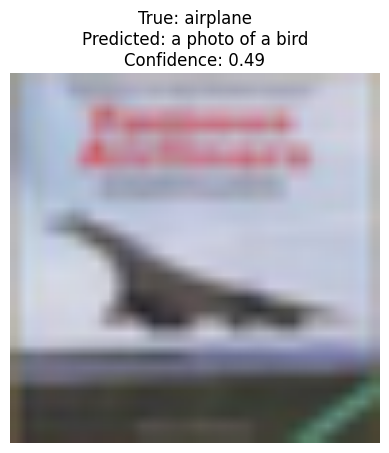

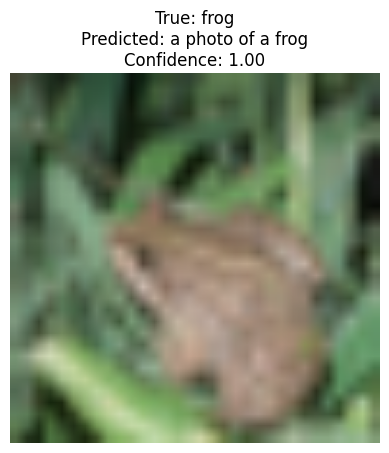

In [7]:
# Step 7: Run CLIP zero-shot prediction on first 5 images
for idx, (img_tensor, true_label) in enumerate(dataloader):
    if idx == 5:
        break

    # Preprocess image for CLIP input
    image_input = preprocess(transforms.ToPILImage()(img_tensor[0])).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        logits_per_image, _ = model(image_input, text_inputs)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Get predicted class and confidence score
    predicted_label = text_labels[np.argmax(probs)]
    confidence_score = np.max(probs)
    true_label_name = class_names[true_label.item()]

    # Display image and prediction result
    plt.imshow(transforms.ToPILImage()(img_tensor[0]))
    plt.axis('off')
    plt.title(f"True: {true_label_name}\nPredicted: {predicted_label}\nConfidence: {confidence_score:.2f}")
    plt.show()